# Predicting booking status of the hotel reservation

### dataset
[hotel-reservations-classification-dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset).
Dataset contains 36275 datapoints

### description
The online hotel reservation channels have dramatically changed booking possibilities and customers’ behavior. A significant number of hotel reservations are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with.

### variables

- Booking_ID: unique identifier of each booking
- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1 - Yes)
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- lead_time: Number of days between the date of booking and the arrival date
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- market_segment_type: Market segment designation.
- repeated_guest: Is the customer a repeated guest? (0 - No, 1 - Yes)
- no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- booking_status: Flag indicating if the booking was canceled or not.


### objective
To predict which reservations will be canceled.

In [1052]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

sns.set_palette("flare")

In [1062]:
df = pd.read_csv("Hotel Reservations.csv")

df.columns = df.columns.str.lower()
df["required_car_parking_space"] = df["required_car_parking_space"].astype(bool)
df["repeated_guest"] = df["repeated_guest"].astype(bool)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   booking_id                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  bool   
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Categorical variables:

In [1063]:
df.select_dtypes(exclude='number').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   booking_id                  36275 non-null  object
 1   type_of_meal_plan           36275 non-null  object
 2   required_car_parking_space  36275 non-null  bool  
 3   room_type_reserved          36275 non-null  object
 4   market_segment_type         36275 non-null  object
 5   repeated_guest              36275 non-null  bool  
 6   booking_status              36275 non-null  object
dtypes: bool(2), object(5)
memory usage: 1.5+ MB


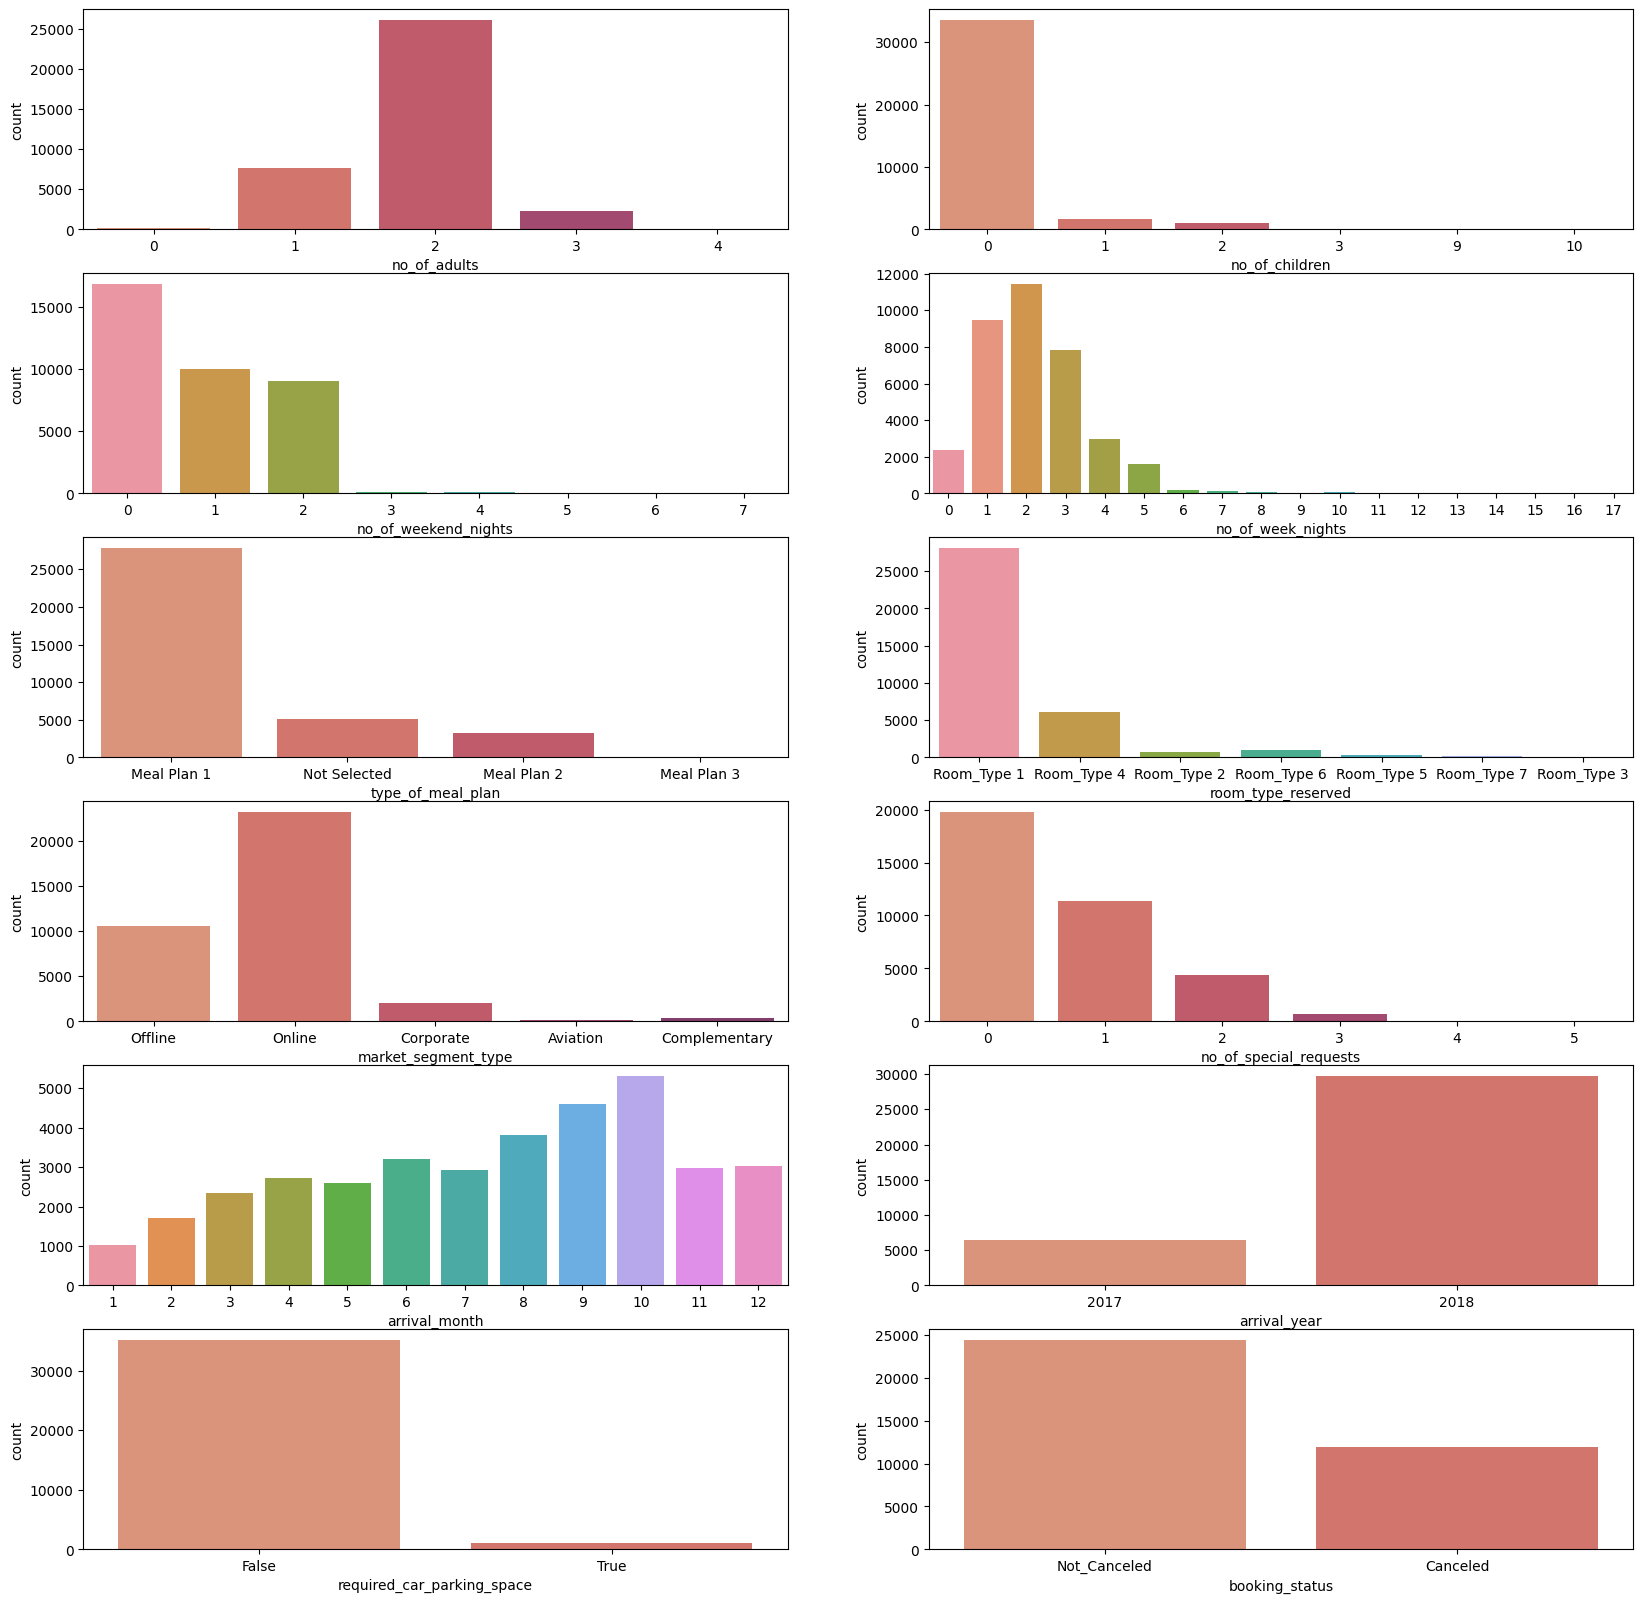

In [1064]:
plt.figure(figsize = (20, 20)) 

columns = [
    "no_of_adults",
    "no_of_children",
    "no_of_weekend_nights",
    "no_of_week_nights",
    "type_of_meal_plan",
    "room_type_reserved",
    "market_segment_type",
    "no_of_special_requests",
    "arrival_month",
    "arrival_year",
    "required_car_parking_space",
    "booking_status",
]

for i, x in enumerate(columns):
    plt.subplot(6, 2, i+1)
    sns.countplot(df, x=x)

Observations:
- Most of the reservations are for 2 adults and no children.
- People usually select meal plan 1 and room type 1.
- Most of the reservation are made online
- Hotel sees highest number of reservations during autumn
- Very few people require parking space
- Class majority problem for `booking_status` (target variable)

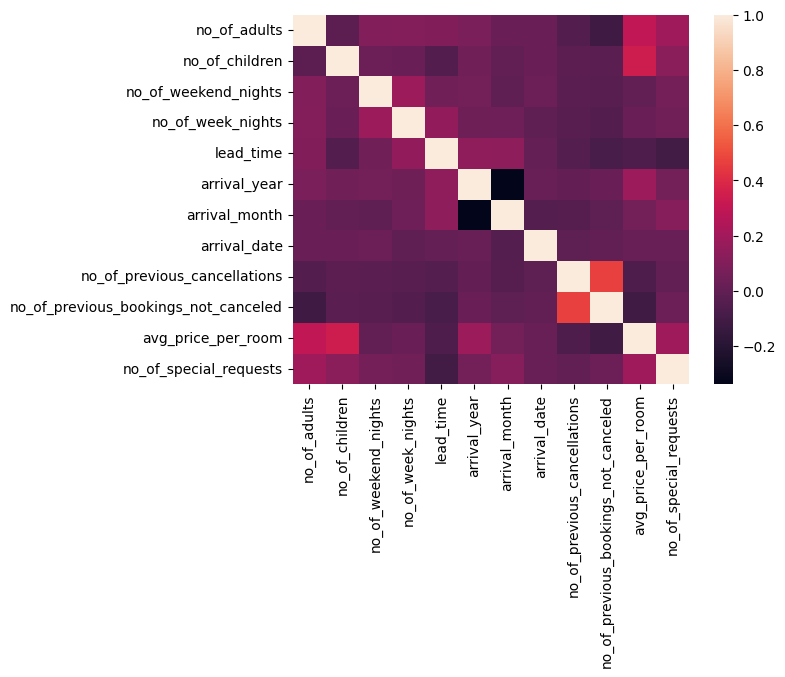

In [1065]:
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

Variables `avg_price_per_room`, `no_of_children`, `no_of_adults` and `no_of_special_requests` seem to be corelated with each other

In [1066]:
df = pd.get_dummies(
    df,
    columns=["type_of_meal_plan", "room_type_reserved", "booking_status", "market_segment_type"],
    prefix=["meal_plan_", "", "status_", "segment_"],
    prefix_sep="",
    dtype=bool
)

df.columns = df.columns.str.lower()
df = df.drop(columns=["booking_id"])
df = df.drop(columns=["status_not_canceled"])
df = df.drop(columns=["arrival_year"])

df.columns = df.columns.str.replace(" ", "_")

Le's fix problem of `status_canceled == False` class majority

In [1067]:
counts = df["status_canceled"].value_counts()
counts

False    24390
True     11885
Name: status_canceled, dtype: int64

In [1068]:
df_majority = df[df["status_canceled"] == False]
df_minority = df[df["status_canceled"] == True]
 
df_majority_downsampled = resample(df_majority, replace=False, n_samples=counts[True], random_state=42)
df_downsampled = pd.concat([df_minority, df_majority_downsampled])

df_downsampled["status_canceled"].value_counts()

True     11885
False    11885
Name: status_canceled, dtype: int64

Create test and train sets:

In [1069]:
X = df_downsampled.loc[:, df.columns != "status_canceled"]
y = df_downsampled["status_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def fit(model):
    model.fit(X_train, y_train)
    
def test(model):
    y_pred = model.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(3, 2))    
    sns.heatmap(cnf_matrix, ax=ax, annot=True, fmt="g")
    plt.ylabel("actual")
    plt.xlabel("predicted")
    plt.show()
    print("accuracy_score: {:.2%}".format(accuracy_score(y_test, y_pred)))
    
def fit_test(model):
    fit(model)
    test(model)

Now, let's create few models and evaluate their preformence

## Logistic Regression

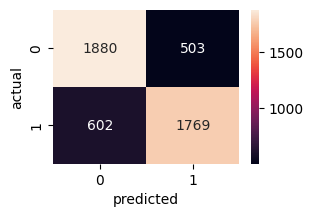

accuracy_score: 76.76%


In [1133]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("regression", LogisticRegression(max_iter=500))
])

fit(model)
test(model)

## Linear SVC

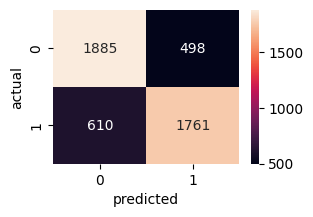

accuracy_score: 76.69%


In [1132]:
model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svc", LinearSVC())
])

fit(model)
test(model)

## KNN Classifier

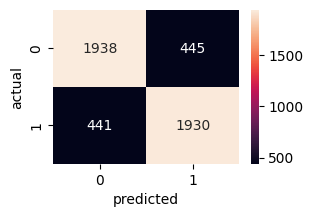

accuracy_score: 81.36%


In [1131]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=3))
])

fit(model)
test(model)

## Decision tree 

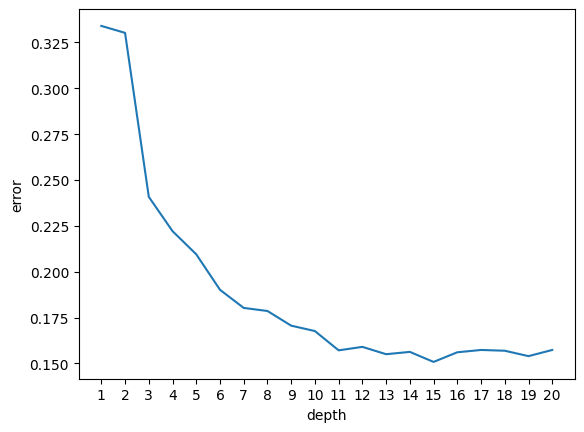

In [979]:
m_err = []
m_depth = []

for x in range(1, 21):
    model = DecisionTreeClassifier(max_depth=x)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    depth = model.get_depth()
    m_err.append(1 - acc)
    m_depth.append(depth)
    
fig, ax = plt.subplots()
ax.plot(m_depth, m_err)
plt.xlabel("depth")
plt.ylabel("error")
plt.xticks(range(1, 21))
plt.show()

With more deep trees we increase complexity and lose advantage of decistion trees - the easiness of interpretation. Above depth 11 we see diminishing returns but let's pick lower value

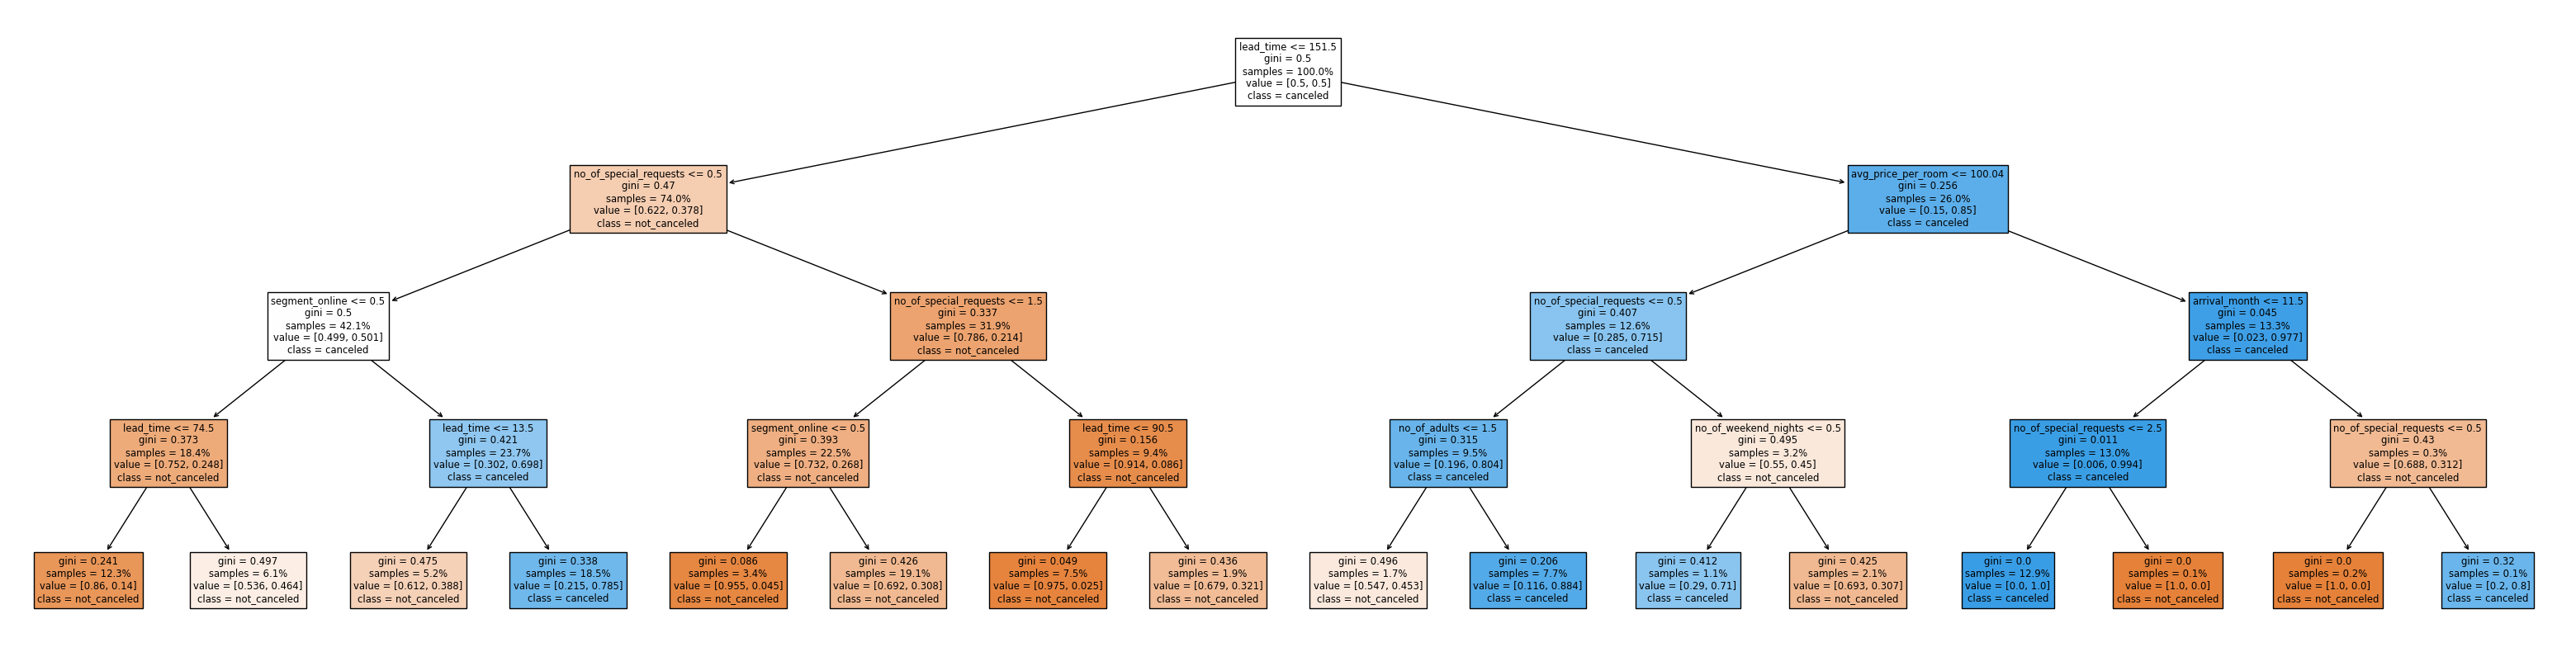

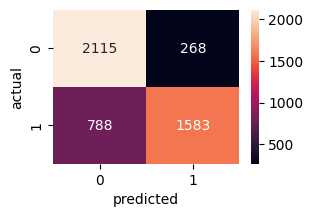

accuracy_score: 77.79%


In [1119]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(40, 10))
plot_tree(model, ax=ax, feature_names=X.columns, class_names=["not_canceled", "canceled"], proportion=True, filled=True)
plt.show()

test(model)

- Confision matrix is not symetric, model more often produces false-negative than false-positive results.
- Accuracy for max_depth set to 4 is similar to accuracy of logistic regression model
- Without pruning tree is full, but few nodes (for example on far right side) have very low influence.


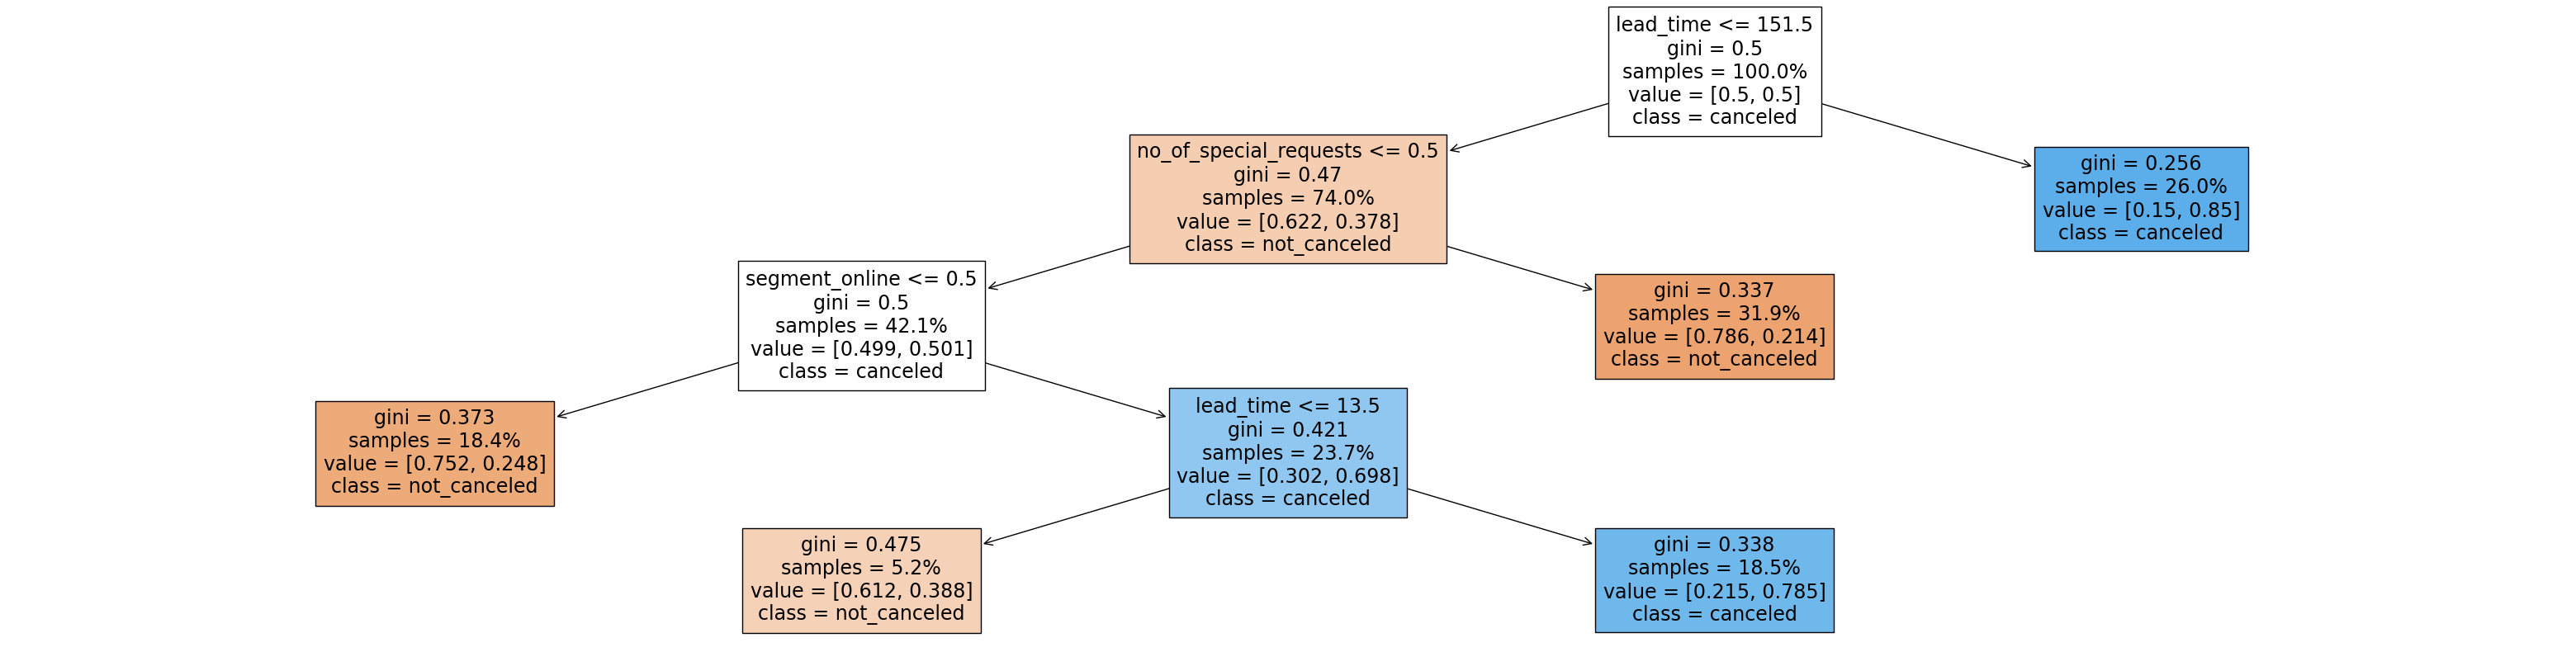

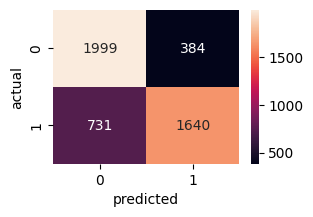

accuracy_score: 76.55%


In [1120]:
model = DecisionTreeClassifier(max_depth=4, ccp_alpha=0.01)
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(40, 10))
plot_tree(model, ax=ax, feature_names=X.columns, class_names=["not_canceled", "canceled"], proportion=True, filled=True)
plt.show()

test(model)

After pruning accuracy dropped by less than 1% but number of nodes decreased significantly.

## AdaBoost

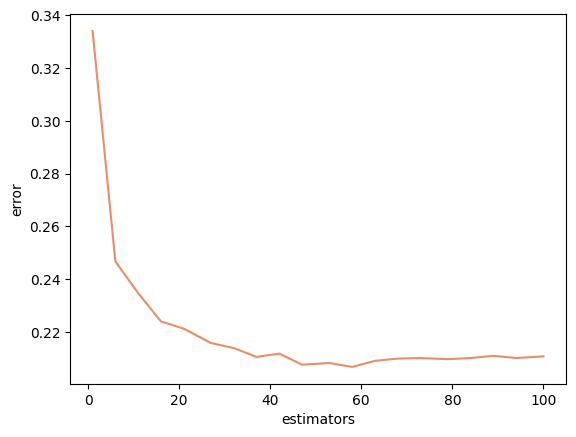

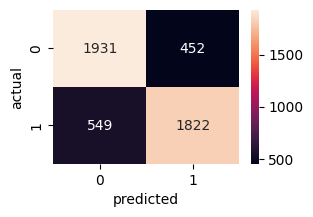

accuracy_score: 78.94%


In [1128]:
m_err = []
m_estimators = []

for x in np.linspace(1, 100, num=20):
    i = int(x)
    model = AdaBoostClassifier(n_estimators=i, base_estimator=DecisionTreeClassifier(max_depth=1))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    m_err.append(1 - acc)
    m_estimators.append(i)
    
fig, ax = plt.subplots()
ax.plot(m_estimators, m_err)
plt.xlabel("estimators")
plt.ylabel("error")
plt.show()

model = AdaBoostClassifier(n_estimators=40, base_estimator=DecisionTreeClassifier(max_depth=1))
model.fit(X_train, y_train)
test(model)

- Increasing number of estimators improves accuracy up to around 40 to 60 estimators.

Upon visualizing all estimators included in model we can see that significant amount of them is using `lead_time` variable. Together with root node of prevoiusly examinated decision tree also using `lead_time`, this observation confirms significance of this variable.

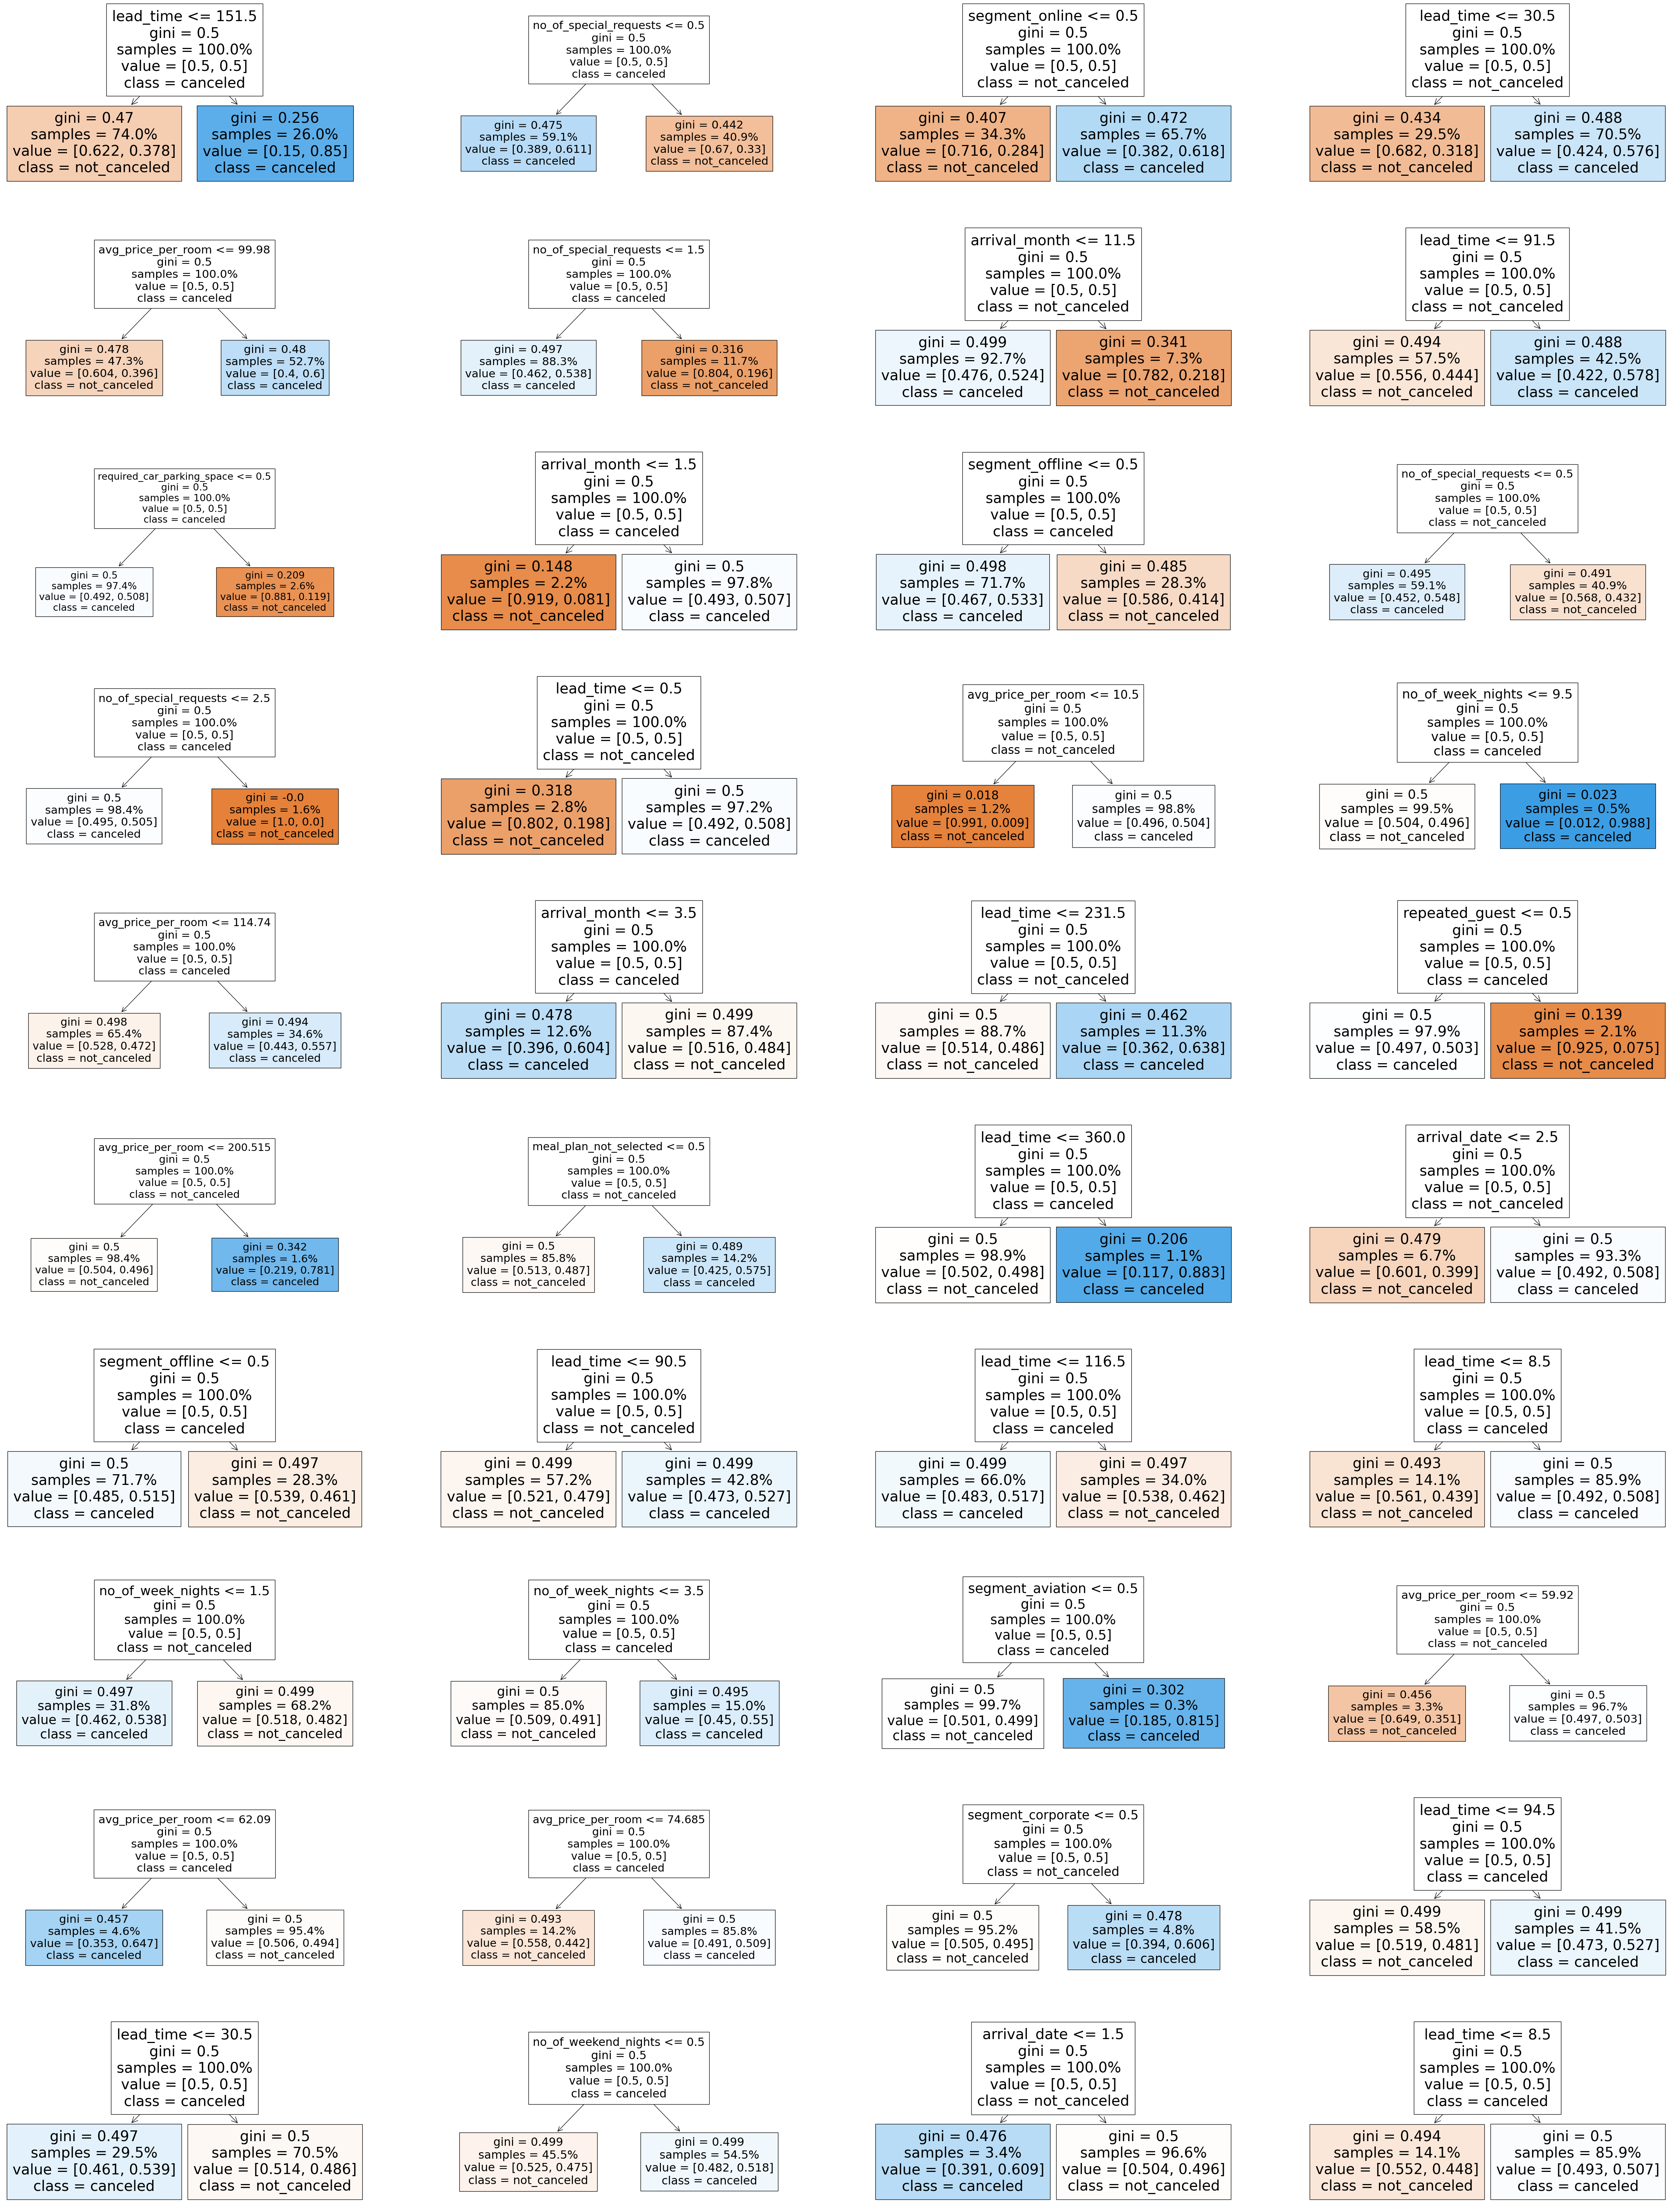

In [1129]:
fig, axes = plt.subplots(10, 4, figsize=(60, 80))
axes = axes.reshape(-1)

for i, ax in enumerate(axes):
    plot_tree(model.estimators_[i], ax=ax, feature_names=X.columns, class_names=["not_canceled", "canceled"], proportion=True, filled=True)

plt.show()